In [ ]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

warnings.simplefilter("ignore")


# Import Datasets


In [ ]:
##DATASETS
import sklearn.datasets 
from sklearn.datasets import openml, fetch_openml
# we use the same file but change datasets accordingly 
digits = sklearn.datasets.load_digits()
credit_g = fetch_openml(name="credit-g")



(1797, 64)


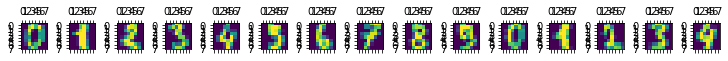

In [ ]:
#Plot digits
print(digits.data.shape)

ncoln = 15
nrow = 1
fig, axes = plt.subplots(ncols=ncoln, nrows=nrow, constrained_layout=True, figsize=(10, 6))
for i in range(ncoln*nrow):
  axes[i].matshow(digits.images[i])
plt.show()

Assuming that no data cleaning needs to be done on the digits image set, 
it looks pretty standard. From running the Train_SoftMax, the normalized data works better and faster. 

In [ ]:
#From LogisticRegression.ipynb
#Define some useful lambda functions
logistic = lambda z: 1./ (1 + np.exp(-z))
cross_entropy = lambda y, yh: -np.mean(np.sum(y* np.log(yh / yh.sum(axis=1)[:, None]), axis = 1)) # I don't know why this is the log_loss function
normalize = lambda X: (X - np.mean(X))/np.std(X)  


In [ ]:
#Better and faster expression for softmax than : 
#softmax = lambda z: np.exp(z - np.max(z)) / np.sum(np.exp(z - np.max(z))) #From here : https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python?noredirect=1&lq=1
def softmax(x, w):
  z = x@w
  normalized = z-np.max(z)
  exp = np.exp(normalized)
  return exp/np.sum(exp)

In [ ]:
# Make a one hot coding. 
# label_encoder is needed when our target is non numerical
def one_hot_coding(Y, label_encoder=False):
  if label_encoder: # if use labels over numerical
    le = LabelEncoder()
    Y = le.fit_transform(Y)
  C = max(Y)+1
  Y_oh = np.zeros((Y.shape[0], C))
  for i in range(Y.shape[0]):
    Y_oh[i, Y[i]] = 1
  return Y_oh


In [ ]:
# From PCA.ipynb
# https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/PCA.ipynb#scrollTo=Wwa2ClZYqpbB
#Add PCA and normalize the X. 
def visualize_normalize(X, bounds=0.9):
  X = normalize(X)
  u, s, vt = np.linalg.svd(X) 
  variances = np.var(X @ vt.T, axis=0)                                      # find the variance of the projected data along each principal component 
  plt.plot(variances/np.sum(variances), label="var. for each PC")           # ratio of the variance along each principal direction
  plt.plot(np.cumsum(variances/np.sum(variances)), label="cumulative var. ratio")
  plt.xlabel("principal component")
  plt.xlim([0,100])
  plt.ylabel("variance ratio")
  plt.legend()
  plt.show()
  
  best = np.argmax(np.cumsum(variances/np.sum(variances)) > bounds)
  print("The index where the cumulative sum is above %.1f is %d" % (bounds, best) )
  X = X @ vt.T
  return X, best


In [ ]:
X = normalize(credit_g.data)

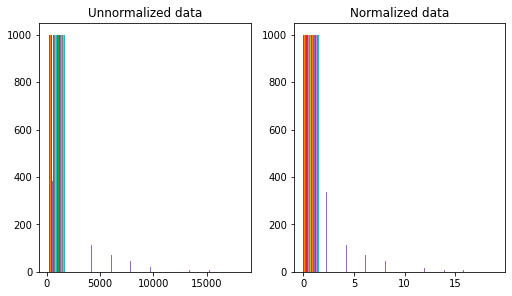

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(7, 4))
axes[0].hist(credit_g.data)
axes[0].set_title("Unnormalized data")
axes[1].hist(X)
axes[1].set_title("Normalized data")
plt.show()



In [ ]:

# X, ind = visualize_normalize(digits.data, bounds=0.90) FOR DIGITS
# X = X[:, :ind] FOR DIGITS
# X = credit_g.data
# Y = one_hot_coding(digits.target) #N x C FOR DIGITS
Y = one_hot_coding(credit_g.target, label_encoder=True) # FOR CREDIT

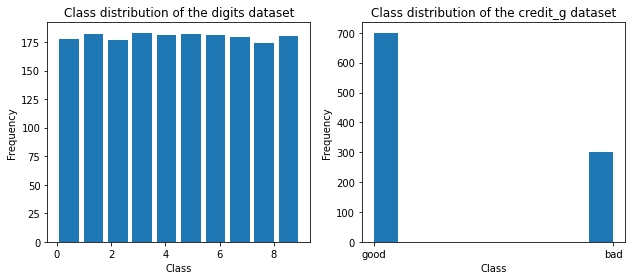

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.hist(digits.target, rwidth = 0.8)
plt.ylabel("Frequency")
plt.xlabel("Class")
plt.title("Class distribution of the digits dataset")

plt.subplot(1, 2, 2)
plt.hist(credit_g.target)
plt.ylabel("Frequency")
plt.xlabel("Class")
plt.title("Class distribution of the credit_g dataset")

fig.tight_layout()


# Stochastic Gradient Descent

mini-batch optimization using gradient descent with
momentum. An instance of this optimizer is passed to the logistic regression class to fit the data.

In [ ]:
#FROM GRADIENTDESENT.ipynb
class GradientDescent:
    
    def __init__(self, learning_rate=.001, momentum=0.9, batch_size=8, max_iters=1e3, max_non_dec=20, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.max_non_dec = max_non_dec
        self.record_history = record_history
        self.epsilon = epsilon

        self.momentum = momentum
        self.batch_size = batch_size
        self.validation_accuracies=[]
        self.training_accuracies=[]
        self.training_errors=[]
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w, xval=None, yval=None, cost_fun=cross_entropy):
        grad = np.inf
        gradw = 0
        t = 1
        t_non_dec = 0
        prev_val_error=np.inf
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            
            m_batches=self.create_mini_batches(x,y)

            for batch in m_batches: 
              x_batch,y_batch= batch
              gradw = self.momentum*gradw + (1-self.momentum)* gradient_fn(x_batch, y_batch, w) 
              w = w - self.learning_rate * gradw

              if self.record_history:
                  self.w_history.append(w)

            t_acc=self.accuracy(x,y,w)
            self.training_accuracies.append(t_acc)

            #if given validation sets, calculate validation accuracy and end when validation error
            #does not decrease for max_non_dec iterations
            if (not xval is None and not yval is None):
              self.validation_accuracies.append(self.accuracy(xval,yval,w))
              if (xval.shape[1] != w.shape[0]):
                #print("Here!")
                N = xval.shape[0]
                xval = np.column_stack([xval,np.ones(N)])
              yh_val=softmax(xval,w)
              val_error=cost_fun(yval, yh_val)
              
              if (not (val_error < prev_val_error) and not t_non_dec==(self.max_non_dec-1)): #Keep track of how many non-decreasing errors
                t_non_dec+=1
              elif (t_non_dec==(self.max_non_dec-1)): #stop if equals max_non_dec
                break
              else: #reset
                t_non_dec=0
              prev_val_error=val_error
            t += 1
        self.w = w
        return self

    # inspired by https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/
    def create_mini_batches(self, x, y):
      m_batches=[]
      D=np.hstack((x,y))
      np.random.shuffle(D)
      num_batches= D.shape[0] // self.batch_size
      i=0
      for i in range(num_batches+1):
        mini_batch = D[i * self.batch_size:(i + 1)*self.batch_size, :] 
        x_mini = mini_batch[:, :x.shape[1]] 
        y_mini = mini_batch[:, x.shape[1]:] 
        m_batches.append((x_mini, y_mini)) 

      if D.shape[0] % self.batch_size != 0: 
        mini_batch = D[i * self.batch_size:D.shape[0]] 
        x_mini = mini_batch[:, :x.shape[1]] 
        y_mini = mini_batch[:, x.shape[1]:]  
        m_batches.append((x_mini, y_mini))
      return m_batches 

    def accuracy( self,x,y,w):
      if (x.shape[1] != w.shape[0]):
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
      yh = softmax(x, w) 

      def compute_confusion_matrix(true, pred): # From Here https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
          result = np.zeros((y.shape[1], y.shape[1]))
          for i in range(len(true)):
            result[true[i]][pred[i]] += 1
          return result
      cm = compute_confusion_matrix(np.argmax(y, 1), np.argmax(yh, 1))
      return np.trace(cm)/np.sum(cm)
      


# SoftmaxRegression

In [ ]:
#Adapted from LinearRegression
class SoftmaxRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
            
    def fit(self, X, y, optimizer, xval=None, yval=None):
        if X.ndim == 1:
            X = X[:, None]
        if self.add_bias:
            N = X.shape[0]
            X = np.column_stack([X,np.ones(N)])
        if y.ndim == 1:
          y = one_hot_coding(y)
        N,D = X.shape
        self.C = y.shape[1]
        def gradient(x, y, w): #X = N x D, Y = N x C (one hot), W = D x C
            if(x.shape[0] == 0):
              return 0
            yh = softmax(x, w) # N x C
            N, D = x.shape
            grad = (.5/N)*(x.T@(yh - y))
            return grad # N x C
        w0 = np.zeros([D, self.C])
        optimizer.run(gradient, X, y, w0, xval, yval)
        self.w = optimizer.w
        self.training_accuracies = optimizer.training_accuracies
        self.validation_accuracies = optimizer.validation_accuracies
        return self
    
    def predict(self, x):
        N = x.shape[0]      
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = softmax(x, self.w) #Returns a N x C array, where it's the likelihood that it belongs to class C
        return yh

    def score(self, x, y):
        yh = np.nan_to_num(self.predict(x))
        def compute_confusion_matrix(true, pred): # From Here https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
          result = np.zeros((self.C, self.C))
          for i in range(len(true)):
            result[true[i]][pred[i]] += 1
          return result
        cm = compute_confusion_matrix(np.argmax(y, 1), np.argmax(yh, 1))
        return np.trace(cm)/np.sum(cm)



# Cross Validation

In [ ]:
#Implements a procedure very similar to sklearns implementation of cross validation. 
class Fold_CV:
  def __init__(self, n_split=5, scramble=False):
    self.n_split=n_split
    self.scramble=scramble
    pass

  def split(self, X):
     N, D = np.shape(X)
     if self.scramble:
       indexes = np.random.permutation(N)
     else :
        indexes = np.arange(N)
     fold_size = int(N/self.n_split)
     
     add_one=(N - fold_size*self.n_split)
     last_ind = 0
     i = 0
     while(i < 5):
      first_ind = last_ind
      if i < add_one:
        last_ind = first_ind + fold_size + 1
      else:
        last_ind = first_ind + fold_size
      i +=1
      yield np.concatenate((indexes[:first_ind], (indexes[last_ind:]))), indexes[first_ind:last_ind]
    
     

In [ ]:
# Used to train various models with Cross Validation. 
# returns average training, validation and time for the model
#Abstraction of a crossvalidation with a model, optimizer, and dataset
def Train_Model(data, targets, model=SoftmaxRegression(), optimizer=None, 
                  number_of_folds=5, scramble=True, sanity_check=False):
  tot_time = 0;
  training_accuracy = 0;
  validation_accuracy = 0;

  kf = Fold_CV(n_split=number_of_folds, scramble=scramble)

  for train_index, test_index in kf.split(data): 

    X, X_Val = data[train_index], data[test_index]
    Y, Y_Val = targets[train_index], targets[test_index]

    start = time.time()
    if (optimizer != None):
      model.fit(X=X, y=Y, xval=X_Val, yval=Y_Val, optimizer=optimizer)
    else:
      model.fit(X=X, y=Y)
    end = time.time()

    if (optimizer != None):
      training_accuracy = training_accuracy + model.training_accuracies[-1]
      validation_accuracy = validation_accuracy + model.validation_accuracies[-1]    
    else:        
      training_accuracy = training_accuracy + model.score(X, Y)
      validation_accuracy = validation_accuracy + model.score(X_Val, Y_Val)
    tot_time = tot_time + (end-start)
    if (sanity_check):
      print(end-start, end=' ')
  if (sanity_check):
    print("\n")
  
  return training_accuracy/number_of_folds, validation_accuracy/number_of_folds, tot_time/number_of_folds #,tot_training, tot_validation

In [ ]:
# For checkpoints for training
# from google.colab import drive
# drive.mount('/content/gdrive')


# Grid Search for Optimal Values

In [ ]:
#Defines a grid search function, where:
# X is Data
# Y is labels
# alphas is a vector of learning rates
# batch_sizes and momentums are both vectors
# sanity_check prints the iteration to actually show that you're making progress
# Returns the training and validation accuracy and the times. 

def GridSearch(X, Y, alphas, batch_sizes, momentums, sanity_check=False):
  validation_accuracy = np.zeros((np.shape(alphas)[0], np.shape(batch_sizes)[0], np.shape(momentums)[0]))
  training_accuracy = np.zeros(np.shape(validation_accuracy))
  train_times = np.zeros(np.shape(validation_accuracy))
  run = 0
  for i in range(np.shape(alphas)[0]):
    if (sanity_check):
      print("\n")
    for j in range(np.shape(batch_sizes)[0]):
      if (sanity_check):
        print("\n")
      for k in range(np.shape(momentums)[0]):
        if(sanity_check):
          print(run, end=' ') #Sanity check 
          run = run + 1
        optimizer = GradientDescent(learning_rate=alphas[i], momentum=momentums[k], batch_size=batch_sizes[j])
        training_accuracy[i, j, k], validation_accuracy[i, j, k], train_times[i, j, k] = Train_Model(X, Y, optimizer=optimizer, sanity_check=sanity_check)
        

  return training_accuracy, validation_accuracy, train_times

In [ ]:
#Either investigate linearily, or in various exponential spaces. 

#number_of_tests = 6 

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1] #np.linspace(0.00001, 0.1, number_of_tests) #6 x 5 folds
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128] #np.arange(1, 32, 3) #  # 6 x 6 x 5 runs
momentums = [0.8, 0.85, 0.9, 0.95, 0.98, 0.99] #np.linspace(0.75, 0.99, number_of_tests) #or  # 6 x 6 x 6 x 5 runs
#print(alphas, "\n", batch_sizes, "\n", momentums)

# PCA is about 2s per run faster, to the max of 5s faster per run. 

# Very slow.... 

#training_accuracy, validation_accuracy, train_times = GridSearch(X, Y, alphas, batch_sizes, momentums, sanity_check=True)
#t2, v2, times_2 = GridSearch(normalize(digits.data), Y, alphas, batch_sizes, momentums, sanity_check=True)

#all_data = []
#all_data.append(training_accuracy)
#all_data.append(validation_accuracy)
#all_data.append( train_times)

#np.save("/content/gdrive/My Drive/551_Ass2_GridSearchData", all_data)

Recommended Score is: 0.9415738161559888

(learning rate = 1, batch size = 1, momentum = 0.98)

It took 7.139015483856201 seconds to run

Absolute Best is :0.9577081398947694 

(learning rate = 0.0001, batch size = 1, momentum = 0.9)

It took 82.70265717506409 seconds to run without early stopping



In [ ]:
#Reload the saved results from the gridsearch
from google.colab import drive
drive.mount('/content/gdrive')
# results = np.load("/content/gdrive/My Drive/551_Ass2_GridSearchData.npy")
results = np.load("/content/gdrive/My Drive/551_Ass2_GridSearchData2.npy")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Re-organize the loaded information 
training_accuracy = results[0]
validation_accuracy = results[1]
train_times = results[2]


# (alphas, batch_size, momentums) = train_times.shape

# Result Visualization

In [ ]:
#Visualization that plots the average of one dimension over the others.
def plot_hyperparameter(hyperparameter, train, val, times, hyper_name):
  def plot_softmax(x, y, name, hyper_name):
    plt.plot(x, y, label=name)
    plt.ylabel("Accuracy")
    plt.xlabel(hyper_name)

  ncols = 2
  nrows = 1
  fig, axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(9, 6))
  plt.subplot(nrows, ncols, 1)
  plt.plot(hyperparameter[np.argmax(val)], np.max(val), 'rx', label='Best')
  plot_softmax(hyperparameter, val, 'Validation', hyper_name)
  plot_softmax(hyperparameter, train, 'Training', hyper_name)
  plt.legend()
  plt.title(f'Accuracy with various {hyper_name}')

  
  plt.subplot(nrows, ncols, 2)
  plot_softmax(hyperparameter, times, 'Times', hyper_name)
  plt.title("Time per run")
  plt.ylabel("Time (s)")

  fig.tight_layout()




Best score is: 0.715 with learning rate = 0.001, batch size = 1, momentum = 0.95
It took 20.150542306900025 seconds to run


Recommended score is: 0.715 with learning rate = 0.001, batch size = 1, momentum = 0.95
It took 20.150542306900025 seconds to run


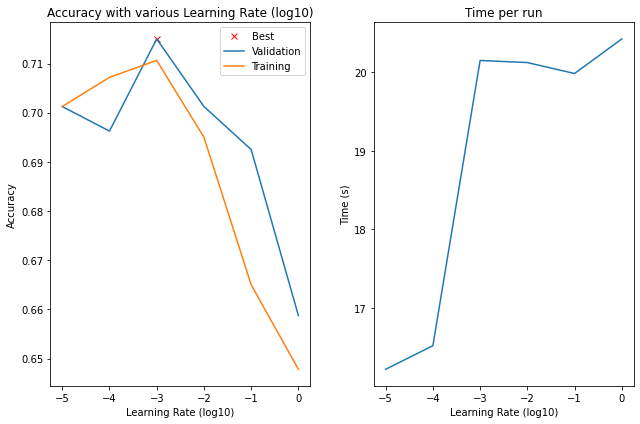

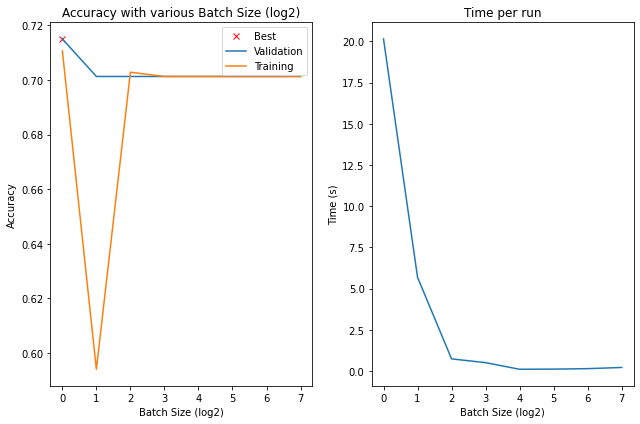

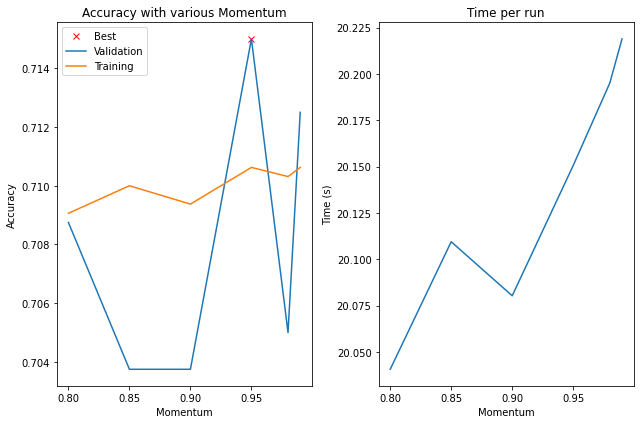

In [ ]:
#Used to visualize grid search
#In reality should be the average, mean or sum over the dimensions. 
def meaned_over_all(train, val, time, axes):
  for i in range(2,-1,-1):
    if (i != axes):
      train = np.mean(train, i)
      val = np.mean(val, i)
      time = np.mean(time, i)
  return train, val, time


#optimal = [1, 0, 2] #Digits
optimal = [2, 0, 3] #Credit

#Credit
t_a, v_a, tm_a = training_accuracy[:, 0, 3], validation_accuracy[:, 0, 3], train_times[:, 0, 3] #meaned_over_all(training_accuracy, validation_accuracy, train_times, 0) # alphas
t_b, v_b, tm_b = training_accuracy[2, :, 3], validation_accuracy[2, :, 3], train_times[2, :, 3] #meaned_over_all(training_accuracy, validation_accuracy, train_times, 1) # batch
t_m, v_m, tm_m = training_accuracy[2, 0, :], validation_accuracy[2, 0, :], train_times[2, 0, :] #meaned_over_all(training_accuracy, validation_accuracy, train_times, 2) # momentum

#Digits
#t_a, v_a, tm_a = training_accuracy[:, 0, 2], validation_accuracy[:, 0, 2], train_times[:, 0, 2] #meaned_over_all(training_accuracy, validation_accuracy, train_times, 0) # alphas
#t_b, v_b, tm_b = training_accuracy[1, :, 2], validation_accuracy[1, :, 2], train_times[1, :, 2] #meaned_over_all(training_accuracy, validation_accuracy, train_times, 1) # batch
#t_m, v_m, tm_m = training_accuracy[1, 0, :], validation_accuracy[1, 0, :], train_times[1, 0, :] #meaned_over_all(training_accuracy, validation_accuracy, train_times, 2) # momentum
plot_hyperparameter(np.log10(alphas), t_a, v_a, tm_a, 'Learning Rate (log10)')
plot_hyperparameter(np.log2(batch_sizes), t_b, v_b, tm_b, 'Batch Size (log2)')
plot_hyperparameter(momentums, t_m, v_m, tm_m, 'Momentum')


#Some how get and print the best values for alpha, batch_size and momentum)
best = np.max(validation_accuracy)
best0 = np.argmax(validation_accuracy, axis=0)
best1 = np.argmax(validation_accuracy, axis=1)
best2 = np.argmax(validation_accuracy, axis=2)
best_1 = np.max(validation_accuracy[train_times < 80])
inds = np.where(validation_accuracy == best_1)
ind = np.where(validation_accuracy == best)

#Get the best scores. 
print(f'Best score is: {best} with learning rate = {alphas[ind[0][0]]}, batch size = {batch_sizes[ind[1][0]]}, momentum = {momentums[ind[2][0]]}')
print(f'It took {train_times[ind[0][0], ind[1][0], ind[2][0]]} seconds to run')
print("\n")
print(f'Recommended score is: {best_1} with learning rate = {alphas[inds[0][0]]}, batch size = {batch_sizes[inds[1][0]]}, momentum = {momentums[inds[2][0]]}')
print(f'It took {train_times[inds[0][0], inds[1][0], inds[2][0]]} seconds to run')



# Comparison Against Other Classifiers

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# max_hyperparameter = 36
models = [GaussianNB()]
for i in range(1, 20):
  models.append(DecisionTreeClassifier(max_depth=i))

for i in range(1, 36,2):
  models.append(KNeighborsClassifier(n_neighbors=i))

train_score = np.zeros(np.shape(models)) 
validation_score = np.zeros(np.shape(models)) 
times = np.zeros(np.shape(models)) 

for i, model in enumerate(models):
  train_score[i], validation_score[i], times[i] = Train_Model(X, np.argmax(Y, axis=1), model=model, optimizer=None)
  #print(f'Model {model} \nTraining accuracy: {train_score}, Validation accuracy: {validation_score}, time: {times}\n')



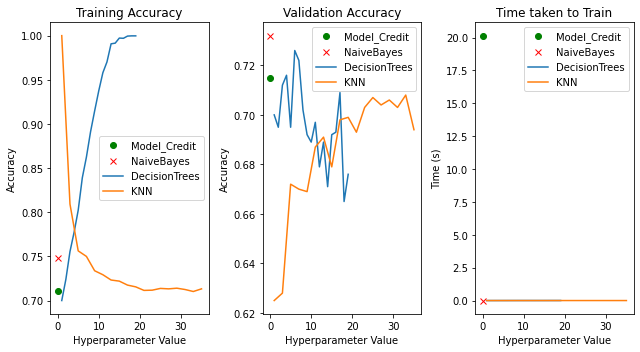

In [ ]:
#Plots the results of the other models as they are to each other. 
def plot_models(ds, name, gnb_ind=0, dtc_ind=20):
  plt.plot(0, ds[gnb_ind],'rx', label='NaiveBayes')
  plt.plot(np.arange(1, dtc_ind), ds[1:dtc_ind],label='DecisionTrees')
  #Brittle
  plt.plot(np.arange(1, 36, 2),ds[dtc_ind:],label='KNN')
  plt.legend()
  plt.title(f'{name} Accuracy')
  plt.ylabel("Accuracy")
  plt.xlabel("Hyperparameter Value")


fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(9, 5))
plt.subplot(1, 3, 1)
plt.plot(0, training_accuracy[inds], 'go', label="Model_Credit")
plot_models(train_score, name='Training')


plt.subplot(1, 3, 2)
plt.plot(0, validation_accuracy[inds], 'go', label="Model_Credit")
plot_models(validation_score, name='Validation')


plt.subplot(1, 3, 3)
plt.plot(0, train_times[inds], 'go', label="Model_Credit")
plot_models(times, name='Time')
plt.title("Time taken to Train")
plt.ylabel("Time (s)")

fig.tight_layout()





# Analysis of Optimization Termination Condition

In [ ]:
#version of Train_Model Function that runs softmax regression with a given optimizer but returns the 
#Training/Validation accuracies at every step of optmimization for every fold 
def Train_Model_Opt_Test(data, targets, model=SoftmaxRegression(), optimizer=None, 
                  number_of_folds=5, scramble=True, sanity_check=False):
  tot_time = 0;
  i=0
  training_accuracy=[]
  validation_accuracy=[]
  kf = Fold_CV(n_split=number_of_folds, scramble=scramble)

  for train_index, test_index in kf.split(data): 

    X, X_Val = data[train_index], data[test_index]
    Y, Y_Val = targets[train_index], targets[test_index]

    start = time.time()
    if (optimizer != None):
      model.fit(X=X, y=Y, xval=X_Val, yval=Y_Val, optimizer=optimizer)
    else:
      model.fit(X=X, y=Y)
    end = time.time()

    if (optimizer != None):
      training_accuracy.append(list(optimizer.training_accuracies))
      validation_accuracy.append(list(optimizer.validation_accuracies))
    
    tot_time = tot_time + (end-start)
    if (sanity_check):
      print(end-start, end=' ')
  if (sanity_check):
    print("\n")
  
  return training_accuracy, validation_accuracy, tot_time 

In [ ]:
#Version of Gradient Descent that does not use early stopping; to use for contrast
class GradientDescentSlow:
    
    def __init__(self, learning_rate=.001, momentum=0.9, batch_size=8, max_iters=1e3, max_non_dec=20, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.max_non_dec = max_non_dec
        self.record_history = record_history
        self.epsilon = epsilon

        self.momentum = momentum
        self.batch_size = batch_size
        self.validation_accuracies=[]
        self.training_accuracies=[]
        self.training_errors=[]
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w, xval=None, yval=None, cost_fun=cross_entropy):
        grad = np.inf
        gradw = 0
        t = 1
        t_non_dec = 0
        prev_val_error=np.inf
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            
            m_batches=self.create_mini_batches(x,y)


            for batch in m_batches: 
              x_batch,y_batch= batch

              gradw = self.momentum*gradw + (1-self.momentum)* gradient_fn(x_batch, y_batch, w)

              w = w - self.learning_rate * gradw
              if self.record_history:
                  self.w_history.append(w)
            
            
            t_acc=self.accuracy(x,y,w)
            self.training_accuracies.append(t_acc)

            #if given validation sets, calculate validation accuracy and end when validation error
            #does not decrease for max_non_dec iterations
            if (not xval is None and not yval is None):
              self.validation_accuracies.append(self.accuracy(xval,yval,w))
              if (xval.shape[1] != w.shape[0]):
                N = xval.shape[0]
                xval = np.column_stack([xval,np.ones(N)])
              yh_val=softmax(xval,w)
              
            t += 1
        self.w = w
        return self

    #https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/
    def create_mini_batches(self, x, y):
      m_batches=[]
      D=np.hstack((x,y))
      np.random.shuffle(D)
      num_batches= D.shape[0] // self.batch_size
      i=0
      for i in range(num_batches+1):
        mini_batch = D[i * self.batch_size:(i + 1)*self.batch_size, :] 
        x_mini = mini_batch[:, :x.shape[1]] 
        y_mini = mini_batch[:, x.shape[1]:] 
        m_batches.append((x_mini, y_mini)) 

      if D.shape[0] % self.batch_size != 0: 
        mini_batch = D[i * self.batch_size:D.shape[0]] 
        x_mini = mini_batch[:, :x.shape[1]] 
        y_mini = mini_batch[:, x.shape[1]:]  
        m_batches.append((x_mini, y_mini))
      return m_batches 

    def accuracy( self,x,y,w):
      if (x.shape[1] != w.shape[0]):
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
      yh = softmax(x, w) 

      def compute_confusion_matrix(true, pred): # From Here https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
          result = np.zeros((y.shape[1], y.shape[1]))
          for i in range(len(true)):
            result[true[i]][pred[i]] += 1
          return result
      cm = compute_confusion_matrix(np.argmax(y, 1), np.argmax(yh, 1))
      return np.trace(cm)/np.sum(cm)
      


In [ ]:
#Train the Softmax Regression model using data from digits dataset and 5-fold cross validation
optimizer_quick = GradientDescent(learning_rate=1, momentum=0.98, batch_size=1)
training_accuracy_quick, validation_accuracy_quick, train_time_quick = Train_Model_Opt_Test(X, Y, optimizer=optimizer_quick)
optimizer_slow= GradientDescentSlow(learning_rate=1, momentum=0.98, batch_size=1)
training_accuracy_slow, validation_accuracy_slow, train_time_slow = Train_Model_Opt_Test(X, Y, optimizer=optimizer_slow)


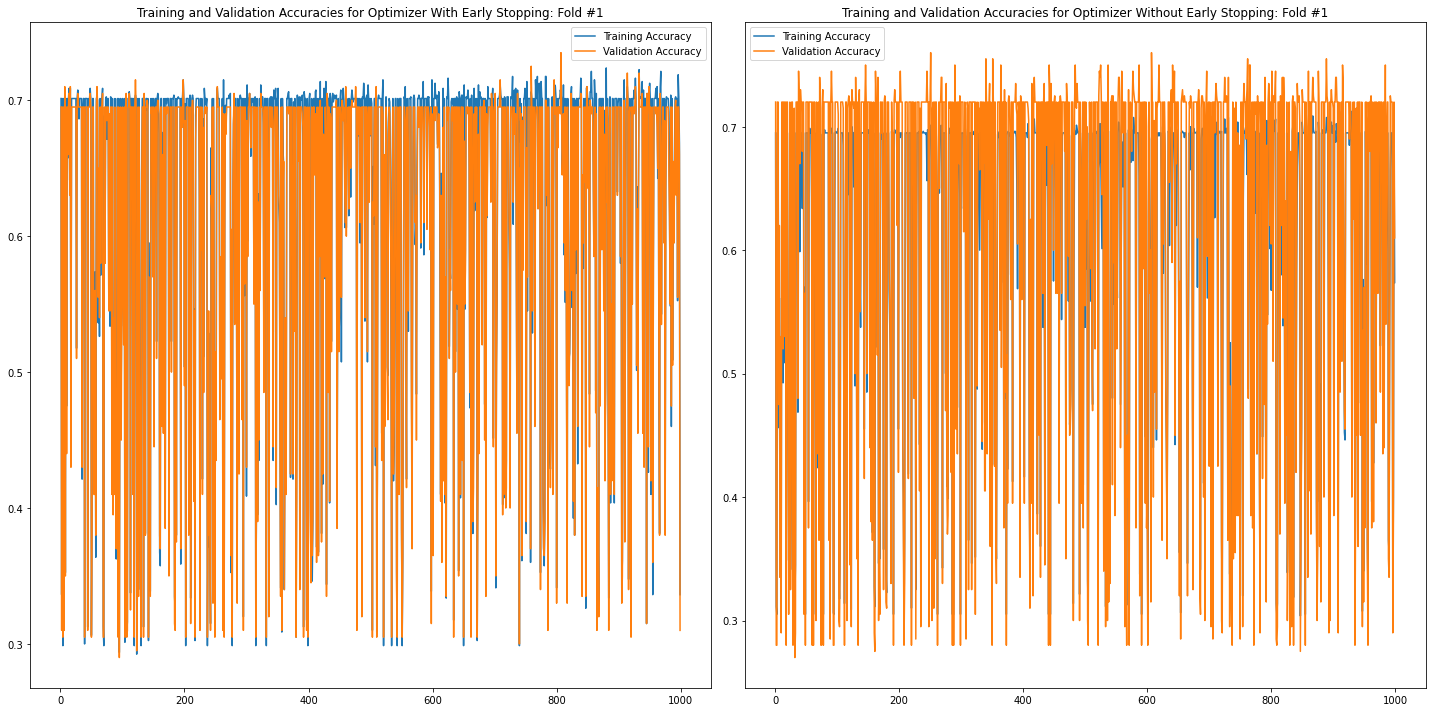

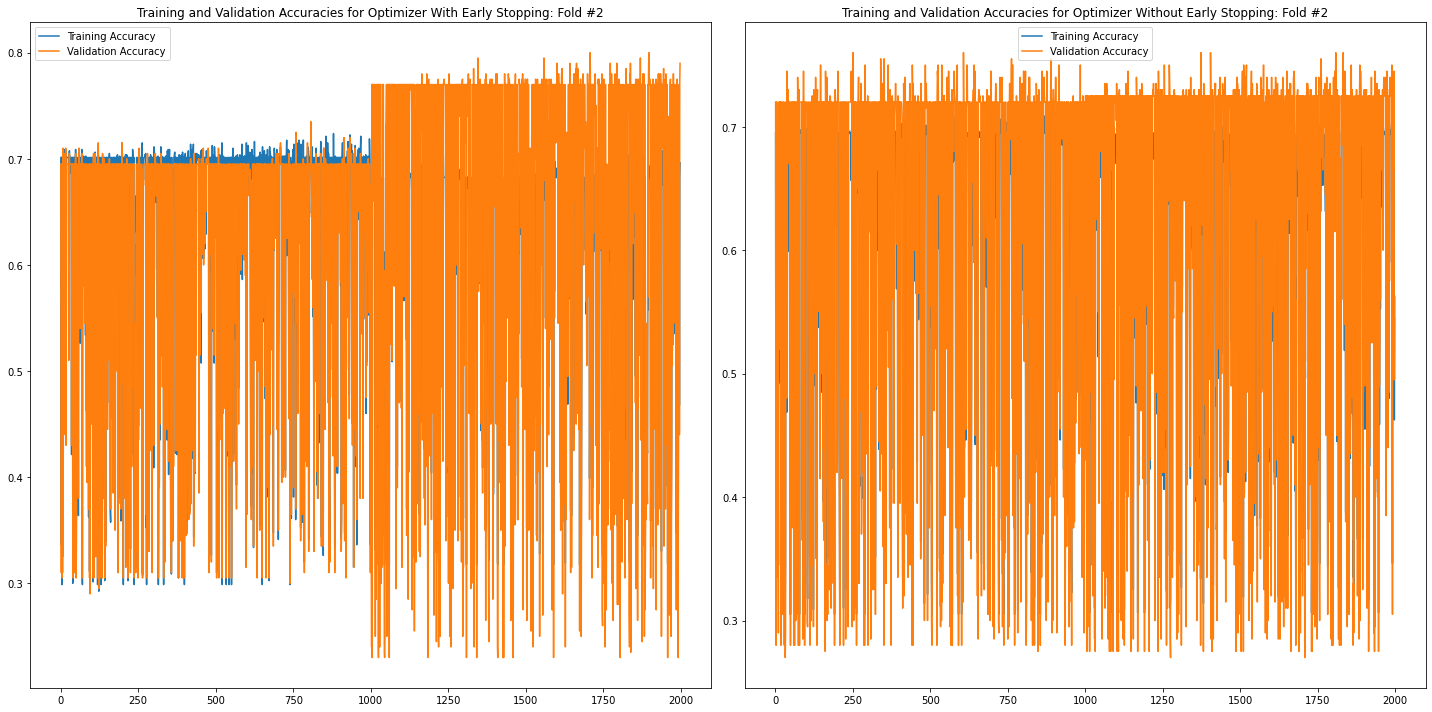

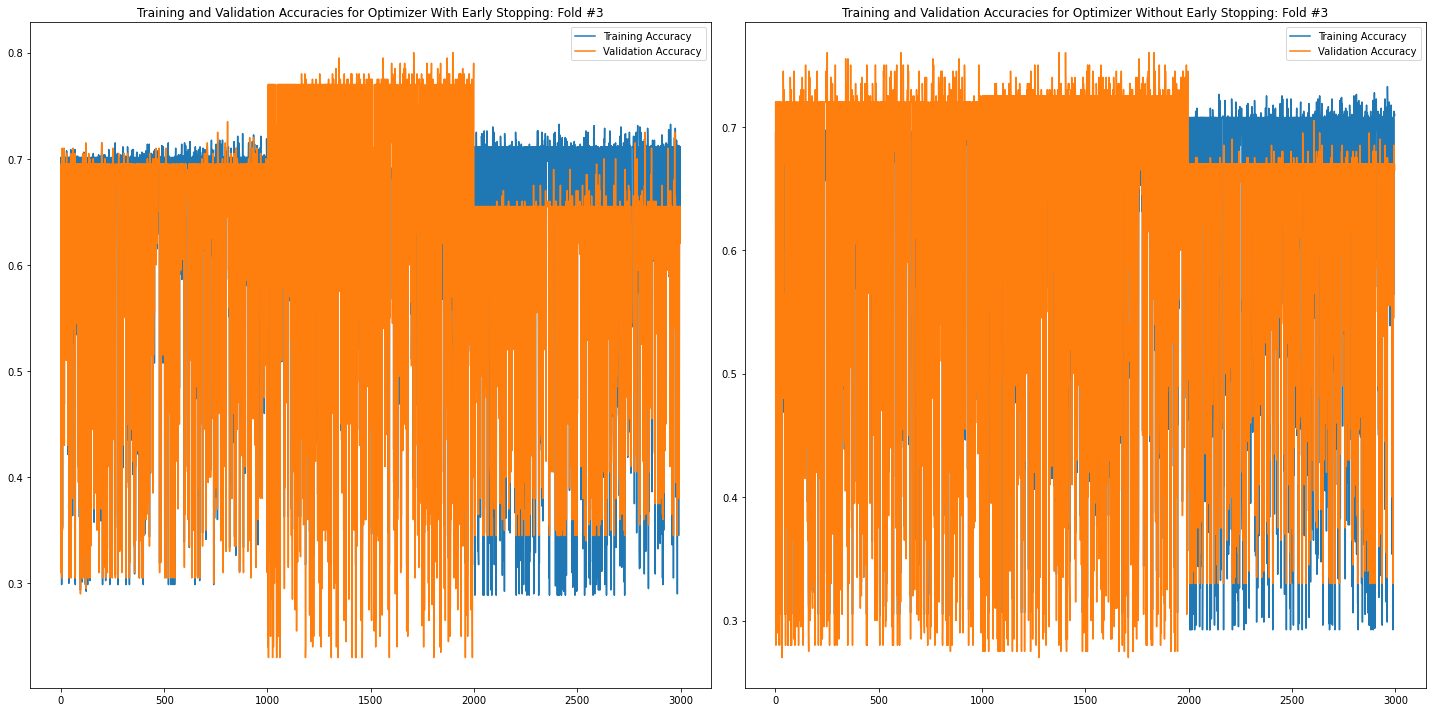

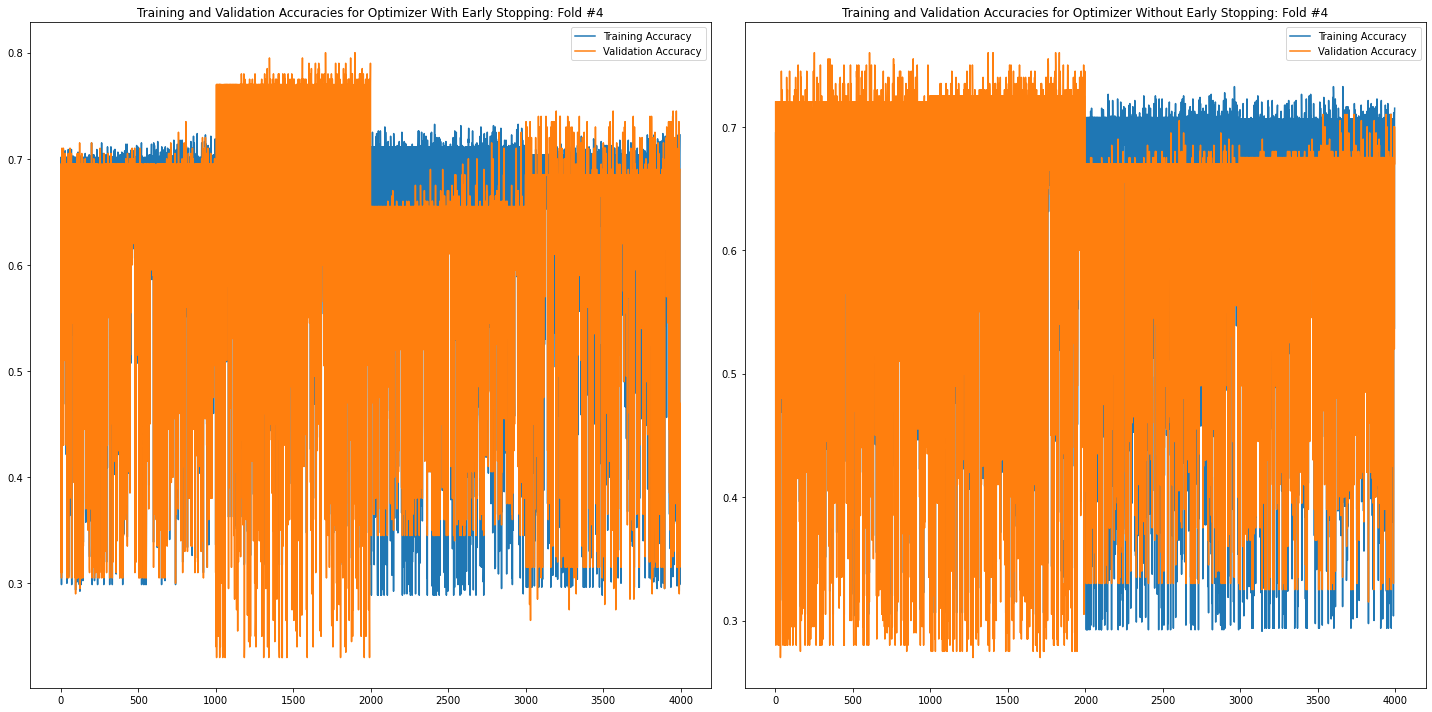

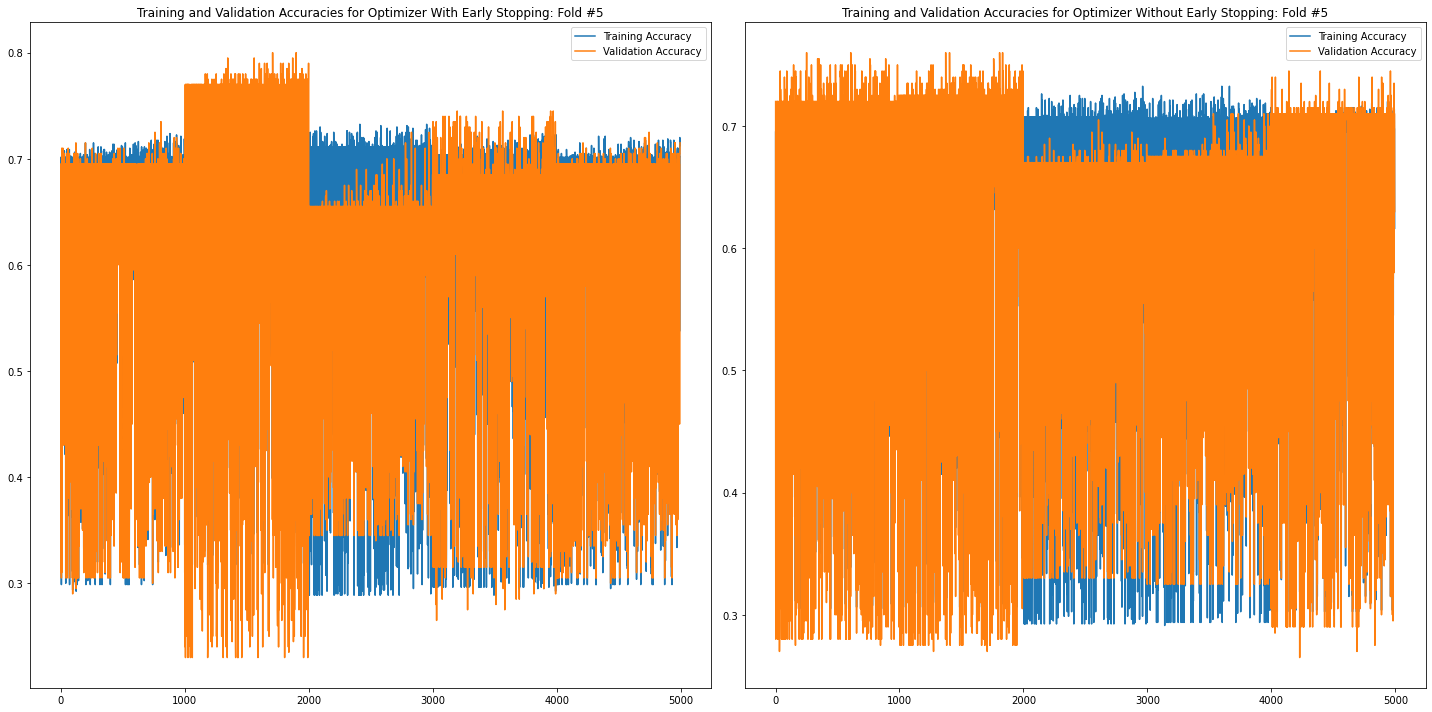

In [ ]:
#plot each the training and validation accuracies of the early stopping algorithm and the basic max-iteration algorithm side by side
#for each fold in the cross validation 
for i in range(0,5):
  training_quick= training_accuracy_quick[i]
  validation_quick= validation_accuracy_quick[i]
  x_quick = np.arange(1,len(training_quick)+1,1)

  training_slow=training_accuracy_slow[i]
  validation_slow=validation_accuracy_slow[i]
  x_slow= np.arange(1, len(training_slow)+1,1)

  fig=plt.figure(figsize=(20, 10))
  ax=plt.subplot(121)
  plt.plot(x_quick, training_quick, label="Training Accuracy")
  plt.plot(x_quick, validation_quick, label="Validation Accuracy")
  plt.title('Training and Validation Accuracies for Optimizer With Early Stopping: Fold #'+str(i+1))
  ax.legend()

  ax=plt.subplot(122)
  plt.plot(x_slow, training_slow, label="Training Accuracy")
  plt.plot(x_slow, validation_slow, label="Validation Accuracy")
  plt.title('Training and Validation Accuracies for Optimizer Without Early Stopping: Fold #'+str(i+1))
  ax.legend()

  fig.tight_layout()
  plt.show()

